# Visual analysis: Order-to-Insight

This notebook contains a small set of targeted visual checks that complement the
SQL-based analysis in the *Order-to-Insight* project.

The goal is **not** to produce dashboards, but to:
- validate time-based aggregations and continuity
- make event incompleteness and data quality signals visible
- support careful interpretation of the modeled analytical layer

All visuals are derived from modeled tables in DuckDB (not raw CSVs) and saved to
`analysis/figures/` so they can be referenced from the README and reviewed without
rerunning the notebook.

In [17]:
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Notebook sijaitsee analysis-kansiossa -> DB löytyy yhden tason ylempää
BASE_DIR = Path("..")
DB_PATH = BASE_DIR / "data" / "processed" / "warehouse.duckdb"

# Tallennetaan kuvat suoraan analysis/figures-kansioon
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Pidetään tyyli yksinkertaisena ja luettavana
plt.style.use("default")

# Varmistetaan, että DB löytyy (helpottaa jos notebook ajetaan väärästä sijainnista)
if not DB_PATH.exists():
    raise FileNotFoundError(
        f"DuckDB warehouse not found at: {DB_PATH}. "
        "Run the pipeline first (ingestion + models) and ensure you're running this notebook from /analysis."
    )

# Avataan yhteys DuckDB-varastoon
con = duckdb.connect(str(DB_PATH))

print("DB path:", DB_PATH)
print("Figures dir:", FIGURES_DIR.resolve())


DB path: ..\data\processed\warehouse.duckdb
Figures dir: C:\Users\honar\Desktop\Projektit\order-to-insight\analysis\figures


## 1) Completed revenue over time (daily)

This visualization shows daily completed revenue based on the modeled
`fact_daily_revenue` table.

The purpose of this figure is validation rather than reporting. Specifically, it is used to:
- assess temporal continuity and aggregation correctness
- identify missing days or unexpected discontinuities
- reveal boundary effects at the start and end of the dataset


In [18]:
query_revenue = """
SELECT
  order_date,
  revenue_completed
FROM fact_daily_revenue
ORDER BY order_date
"""

df_rev = con.execute(query_revenue).df()

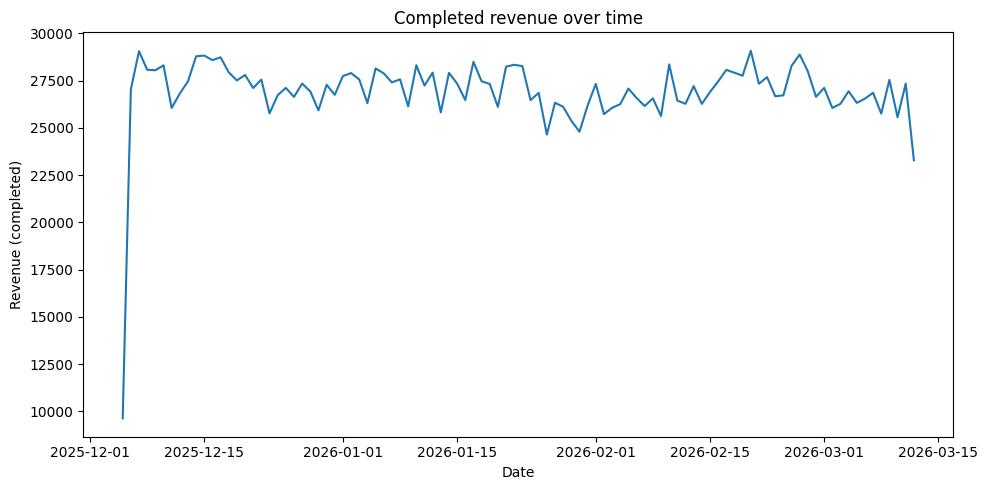

Saved: figures\revenue_over_time.png


In [20]:
plt.figure(figsize=(10, 5))
plt.plot(df_rev["order_date"], df_rev["revenue_completed"])
plt.title("Completed revenue over time")
plt.xlabel("Date")
plt.ylabel("Revenue (completed)")
plt.tight_layout()

out_path = FIGURES_DIR / "revenue_over_time.png"
plt.savefig(out_path)
plt.show()

print("Saved:", out_path)


### Interpretation

Daily completed revenue remains structurally stable throughout the period,
which is expected given the controlled nature of the synthetic dataset.

The lower revenue observed at the beginning and end of the time range is most
likely caused by partial ingestion windows at the dataset boundaries rather
than genuine business fluctuations.

**Production note:** In real-world data, this visualization is a primary tool
for detecting missing days, ingestion issues, unexpected revenue drops, and
seasonality or campaign-driven effects.

---

## 2) Event coverage across orders (%)

This figure shows the share of orders with a non-null timestamp for each lifecycle event
in the modeled `fact_orders` table.

This is a core validation view for the project: it quantifies event completeness and makes
explicit how much analytical signal would be lost if metrics were derived from events alone.


In [21]:
# Lasketaan eventtien kattavuus prosentteina fact_orders-taulusta
query_event_coverage = """
SELECT
  ROUND(100.0 * SUM(CASE WHEN created_event_ts   IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_created,
  ROUND(100.0 * SUM(CASE WHEN payment_event_ts   IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS payment_confirmed,
  ROUND(100.0 * SUM(CASE WHEN shipped_event_ts   IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_shipped,
  ROUND(100.0 * SUM(CASE WHEN cancelled_event_ts IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_cancelled
FROM fact_orders
"""

df_cov = con.execute(query_event_coverage).df()
df_cov


,order_created,payment_confirmed,order_shipped,order_cancelled
0,100.0,89.55,89.4,8.0


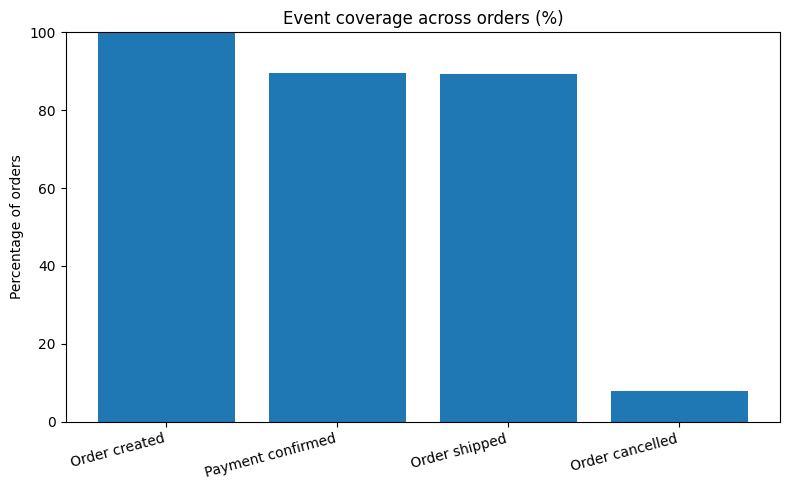

Saved: figures\event_coverage.png


In [24]:
coverage = df_cov.iloc[0]

labels = [
    "Order created",
    "Payment confirmed",
    "Order shipped",
    "Order cancelled"
]

values = coverage.values.tolist()

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title("Event coverage across orders (%)")
plt.ylabel("Percentage of orders")
plt.ylim(0, 100)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()

out_path = FIGURES_DIR / "event_coverage.png"
plt.savefig(out_path)
plt.show()

print("Saved:", out_path)


### Interpretation

Nearly all orders have an `order_created` event, but around ~10% are missing either
`payment_confirmed` or `order_shipped` timestamps.

This creates a direct analytical risk: funnel, lead-time, or operational metrics derived purely
from event data will systematically undercount orders and can bias time-based conclusions.

The figure supports the project’s central point: transactional status and event streams must be
reconciled, and event completeness should be measured explicitly before drawing business conclusions.

Coverage is computed at the order level from modeled event timestamps, where a NULL value indicates
a missing or unrecorded event.

---

## 3) Missing lifecycle events among completed orders

The overall event coverage analysis shows that not all orders have complete lifecycle events.
In this section, the focus is narrowed specifically to **completed orders** to quantify how often
key events are missing even in the highest-value segment.

This distinction matters because missing events among completed orders can bias:
- funnel metrics (e.g. paid → completed)
- lead-time KPIs (payment → shipment)
- operational analyses derived from event logs


In [12]:
# Lasketaan completed-tilausten määrä sekä kuinka monelta puuttuu maksutapahtuma / toimitustapahtuma
query_completed_missing = """
SELECT
  SUM(CASE WHEN order_status = 'completed' THEN 1 ELSE 0 END) AS completed_total,
  SUM(CASE WHEN order_status = 'completed' AND payment_event_ts IS NULL THEN 1 ELSE 0 END) AS completed_missing_payment,
  SUM(CASE WHEN order_status = 'completed' AND shipped_event_ts IS NULL THEN 1 ELSE 0 END) AS completed_missing_shipment
FROM fact_orders
"""

df_cm = con.execute(query_completed_missing).df()
df_cm


,completed_total,completed_missing_payment,completed_missing_shipment
0,17848.0,477.0,0.0


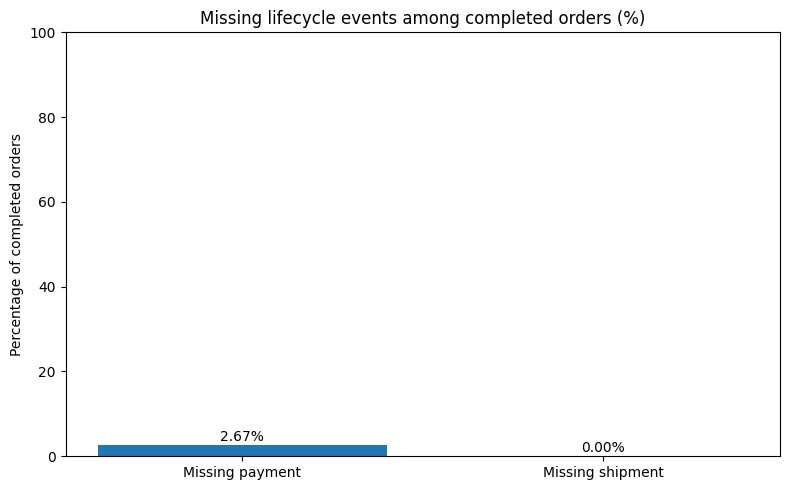

Saved: figures\completed_missing_events.png


In [16]:
# Muutetaan luvut helpommin käsiteltävään muotoon
completed_total = int(df_cm.loc[0, "completed_total"])
missing_payment = int(df_cm.loc[0, "completed_missing_payment"])
missing_shipment = int(df_cm.loc[0, "completed_missing_shipment"])

# Lasketaan prosenttiosuudet (completed-tilauksista)
pct_missing_payment = 100.0 * missing_payment / completed_total if completed_total else 0.0
pct_missing_shipment = 100.0 * missing_shipment / completed_total if completed_total else 0.0

labels = ["Missing payment", "Missing shipment"]
values = [pct_missing_payment, pct_missing_shipment]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title("Missing lifecycle events among completed orders (%)")
plt.ylabel("Percentage of completed orders")
plt.ylim(0, 100)
plt.tight_layout()

# Lisätään prosenttiluvut pylväiden päälle (presentaatioparannus)
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=10)

out_path = FIGURES_DIR / "completed_missing_events.png"
plt.savefig(out_path)
plt.show()

print("Saved:", out_path)


### Interpretation

Among completed orders, missing lifecycle events are relatively uncommon but still analytically relevant.
Approximately 2.7% of completed orders lack a payment confirmation event, while shipment events
are present for all completed orders in this dataset.

This implies that revenue, funnel, or lead-time analyses derived purely from payment events
would slightly undercount completed orders unless missingness is handled explicitly.

The absence of missing shipment events among completed orders suggests that shipment-related
data quality issues are primarily concentrated in non-completed orders (e.g. cancellations),
which is consistent with the earlier event coverage analysis.

Percentages are computed relative to completed orders only, with missingness defined as a NULL event timestamp.

